In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [4]:
# Import tqdm for progress bar construction
import tqdm

In [5]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [6]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# from google.colab import drive
# drive.mount('/content/gdrive')


# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [7]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [8]:
# Modify dataframe for K-Fold Cross Validation (ff1010)
ff1010_csv = pandas.read_csv(FF1010_Path + 'metadata.csv')
ff1010_csv.loc[ff1010_csv['hasbird'] == 0, 'filepath'] = \
    FF1010_Path + 'nocall/' + ff1010_csv.query('hasbird == 0')['filename'] + '.npy'
ff1010_csv.loc[ff1010_csv['hasbird'] == 1, 'filepath'] = \
    FF1010_Path + 'bird/' + ff1010_csv.query('hasbird == 1')['filename'] + '.npy'

ff1010_csv = ff1010_csv.dropna()
ff1010_csv = ff1010_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
ff1010_dataframe = ff1010_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(ff1010_dataframe, ff1010_dataframe['hasbird'])):
    ff1010_dataframe.loc[nth_groups, 'fold'] = int(n)

In [9]:
# # Modify dataframe for K-Fold Cross Validation (birdclef2021)
# birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
# birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
#     AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
#     birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

# birdclef_csv = birdclef_csv.dropna()
# birdclef_csv = birdclef_csv.reset_index(drop=True)

# # Add 'fold' attribute for dataset classification
# birdclef_dataframe = birdclef_csv.copy()
# for n, (_, nth_groups) in enumerate(
#     skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
#     birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [10]:
# Hyper-parameters for training 
ff1010_batch = 32
birdclef_batch = 32

Model 1 (No-call detector)

In [11]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [12]:
def evaluate_model(loader, model, beta=1.0):
  print("Checking accuracy score on validation set.")
  # TODO: extend this so that we can print that we evaluate test set.
  num_correct = 0
  num_samples = 0
  log_sum = 0
  fbeta_sum = 0
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=torch.float)
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
      # In binary classification, it should be (batch size, 2) sized tensor

      # Checks naive accuracy.
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)

      # Checks Log Loss.
      log_loss = F.nll_loss(F.log_softmax(scores), y)
      log_sum += log_loss.sum() * preds.size(0)

      # Checks Fbeta-score.
      fbeta = fbeta_score(preds, y, beta=beta)
      fbeta_sum += fbeta * preds.size(0)

    acc = float(num_correct) / num_samples
    log_score = log_sum / num_samples
    f_score = fbeta_sum / num_samples
    print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('Log Loss score:\t%.2f' % (log_score))
    print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
  return acc, log_score, f_score

Let's train with model 1.

In [21]:
# Print period for accuracy.
print_period = 12

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device))
]))

print(model_1)

def train_model(model, train_loader, val_loader, optimizer, beta=1.0, epoch=7):
    val_losses = []
    train_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores), y) # Log loss for our project.
            train_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)
#         print()

    return val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [22]:
# from time import sleep

# Train loop for nocall detector
def nocall_train(train_dataframe, val_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    
    # Test for loaders
    
    optimizer = optim.SGD(model_1.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
    val_losses, train_losses, log_scores, fbeta_scores = train_model(model_1, train_loader, val_loader, optimizer, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores

In [23]:
# Train, Validate and Test for nocall detector
def nocall(dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores = nocall_train(train_dataframe, val_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores

In [24]:
val_losses, train_losses, log_scores, fbeta_scores = nocall(ff1010_dataframe, 0, 1)

Training model 1, epoch 1


  0%|                                                                                          | 0/144 [00:00<?, ?it/s]C:\Users\youngrae\AppData\Local\Temp/ipykernel_20104/158187342.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = F.nll_loss(F.log_softmax(scores), y) # Log loss for our project.
  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.17it/s]

Iteration 0, loss = 0.8645


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.62it/s]

Iteration 12, loss = 0.7506


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.56it/s]

Iteration 24, loss = 0.6068


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.5531


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.67it/s]

Iteration 48, loss = 0.4132


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.4263


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.6744


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.65it/s]

Iteration 84, loss = 0.5006


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:18,  2.58it/s]

Iteration 96, loss = 0.4699


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.6002


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.3914


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.3516


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.26it/s]


Checking accuracy score on validation set.


C:\Users\youngrae\AppData\Local\Temp/ipykernel_20104/4133346658.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_loss = F.nll_loss(F.log_softmax(scores), y)



Accuracy: 1197 / 1538 correct (77.83)
Log Loss score:	0.50
Fbeta-score (beta=1): 	0.78
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.6237


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.5196


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.69it/s]

Iteration 24, loss = 0.6051


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.5930


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.69it/s]

Iteration 48, loss = 0.4717


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.69it/s]

Iteration 60, loss = 0.3286


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.69it/s]

Iteration 72, loss = 0.5140


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:21,  2.69it/s]

Iteration 84, loss = 0.3876


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.6229


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:32<00:13,  2.67it/s]

Iteration 108, loss = 0.3152


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.61it/s]

Iteration 120, loss = 0.4501


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.3201


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.32it/s]


Checking accuracy score on validation set.

Accuracy: 1297 / 1538 correct (84.33)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.84
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:47,  3.00it/s]

Iteration 0, loss = 0.1887


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.3698


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.4610


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.58it/s]

Iteration 36, loss = 0.3923


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.66it/s]

Iteration 48, loss = 0.6052


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:30,  2.68it/s]

Iteration 60, loss = 0.2190


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.4075


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:21,  2.68it/s]

Iteration 84, loss = 0.4986


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.3662


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.68it/s]

Iteration 108, loss = 0.3624


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.68it/s]

Iteration 120, loss = 0.2571


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.68it/s]

Iteration 132, loss = 0.2895


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1306 / 1538 correct (84.92)
Log Loss score:	0.40
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.23it/s]

Iteration 0, loss = 0.2195


  9%|███████▎                                                                         | 13/144 [00:03<00:48,  2.68it/s]

Iteration 12, loss = 0.4024


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.4840


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.2441


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:36,  2.64it/s]

Iteration 48, loss = 0.4967


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.60it/s]

Iteration 60, loss = 0.3998


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.3793


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.68it/s]

Iteration 84, loss = 0.4721


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.68it/s]

Iteration 96, loss = 0.4882


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.65it/s]

Iteration 108, loss = 0.2430


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.67it/s]

Iteration 120, loss = 0.3172


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.68it/s]

Iteration 132, loss = 0.4397


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1311 / 1538 correct (85.24)
Log Loss score:	0.39
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.4082


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.2703


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.3120


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.66it/s]

Iteration 36, loss = 0.2854


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.6409


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.60it/s]

Iteration 60, loss = 0.2330


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.65it/s]

Iteration 72, loss = 0.3417


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.67it/s]

Iteration 84, loss = 0.1249


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.67it/s]

Iteration 96, loss = 0.3442


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.67it/s]

Iteration 108, loss = 0.3894


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.68it/s]

Iteration 120, loss = 0.1914


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.3424


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.30it/s]


Checking accuracy score on validation set.

Accuracy: 1292 / 1538 correct (84.01)
Log Loss score:	0.39
Fbeta-score (beta=1): 	0.84
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.25it/s]

Iteration 0, loss = 0.3890


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.66it/s]

Iteration 12, loss = 0.3154


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.66it/s]

Iteration 24, loss = 0.3531


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.67it/s]

Iteration 36, loss = 0.2076


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.2889


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.2967


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.66it/s]

Iteration 72, loss = 0.4470


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.3866


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.65it/s]

Iteration 96, loss = 0.2654


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.66it/s]

Iteration 108, loss = 0.2109


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:36<00:08,  2.64it/s]

Iteration 120, loss = 0.4786


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.67it/s]

Iteration 132, loss = 0.5169


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1291 / 1538 correct (83.94)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.84
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.19it/s]

Iteration 0, loss = 0.3561


  9%|███████▎                                                                         | 13/144 [00:03<00:49,  2.67it/s]

Iteration 12, loss = 0.4048


 17%|██████████████                                                                   | 25/144 [00:07<00:44,  2.67it/s]

Iteration 24, loss = 0.3206


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.2818


 34%|███████████████████████████▌                                                     | 49/144 [00:14<00:35,  2.67it/s]

Iteration 48, loss = 0.1796


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.66it/s]

Iteration 60, loss = 0.3374


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.67it/s]

Iteration 72, loss = 0.1999


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:25<00:22,  2.66it/s]

Iteration 84, loss = 0.3563


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.66it/s]

Iteration 96, loss = 0.3456


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.59it/s]

Iteration 108, loss = 0.6053


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.65it/s]

Iteration 120, loss = 0.1780


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:40<00:04,  2.66it/s]

Iteration 132, loss = 0.3465


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:43<00:00,  3.29it/s]


Checking accuracy score on validation set.

Accuracy: 1326 / 1538 correct (86.22)
Log Loss score:	0.37
Fbeta-score (beta=1): 	0.86


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

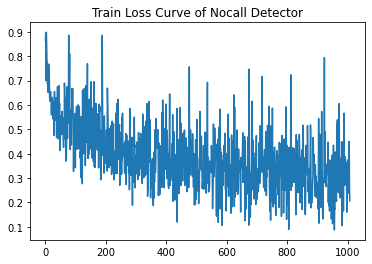

In [25]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

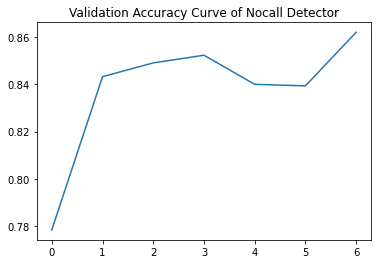

In [26]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

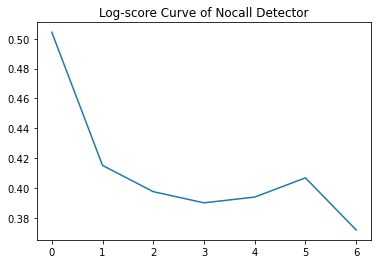

In [27]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

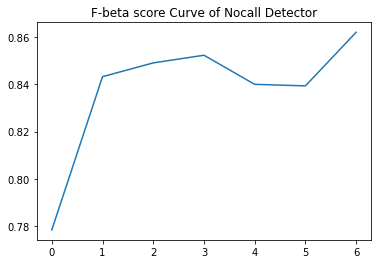

In [28]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

Model 2 (Bird classificator)

In [ ]:
# Class for mel-spectrogram images dataset
class AudioImage(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        augmented = torch.zeros(N, C, H, W).to(device)
        for i in range(N):
            augmented[i] = self.transform(Image.fromarray(source[i])).to(device)
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

In [ ]:
# Train loop for bird specification
def bird_train(train_dataframe, val_dataframe):  
    train_data = AudioImage(train_dataframe, process='train', labels='label_id')
    val_data = AudioImage(val_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    
    # Test for loaders
    
    # TODO
    # 이쪽에 training 구현하시면 됩니다.
    for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
        sleep(0.01)
        
    # TODO
    # 이쪽에 validation 구현하시면 됩니다.
    for index, (source, label) in enumerate(tqdm.tqdm(val_loader)):
        sleep(0.01)
    
    val_losses = None
    train_losses = None
    return val_losses, train_losses

In [ ]:
# Train, Validate and Test for bird specification
def bird(dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses = bird_train(train_dataframe, val_dataframe)
    
    # TODO
    # 이쪽에 Accuracy test 구현하시면 됩니다.
    
    return

In [ ]:
bird(birdclef_dataframe, 0, 1)